# Before you use this notebook

## Disable Data Execution Prevention - DEP
1. Type cmd in the start search menu, **right-click** on it and select **Run as Administrator**.
2. Once the command prompt is open, you can now disable [Data Execution Prevention](https://pt.wikipedia.org/wiki/Data_Execution_Prevention) (DEP) by entering the following command line.
        bcdedit.exe /set nx AlwaysOff
3. And to enable it back,
        bcdedit.exe /set nx AlwaysOn

## Conda env config

Download [miniconda](https://conda.io/miniconda.html) (python 3.X - 64bit):

    set CONDA_FORCE_32BIT=1
    conda create -n py3_32bit python=3 numpy matplotlib seaborn pandas
    activate py3_32bit

**NOTE**: Always remember to `set CONDA_FORCE_32BIT=1` before activating env.

In [1]:
import numpy as np

# Fluid Density
ρ_L = 1000 # [kg/m3]
ρ_G =    2 # [kg/m3]
ρ   = [ρ_L, ρ_G]

# Fluid Viscosity
μ_L = 1e-3 # [Pa.s]
μ_G = 1e-5 # [Pa.s]
μ   = [μ_L, μ_G]

# Surface Tension
σ = 0.07 # [N/m]

# Pipe Diameter
D = 0.1 # [m]

# Pipe Angle
θ = np.deg2rad(0.0) # [rad]

# Pipe Roughness
k_s = 4e-5 # [m]

# Interface
SMOOTH = 1
WAVY   = 2
interface = 1

In [2]:
import os
from ctypes import *
os.environ["PATH"] += 'bin'
pat_flow = windll.LoadLibrary('PatFlow.dll')

In [3]:
def calculate_flow_pattern_transition(ρ, μ, σ, D, θ, k_s, interface, Nt=6, n=40, nc=5):
    """
    Nt = 6  # Number of Transition
    n  = 40 # Number of points
    nc = 5  # Number of cicles
    
    """
    prop = [ρ[0], μ[0], σ, ρ[1], μ[1], D, θ, k_s, interface]
    


    # Output Variables
    Tr   = np.zeros((n*nc, Nt*2), dtype=np.float64) # Transition Matrix
    E_Tr = np.ones((n*nc, Nt  ), dtype=np.int)      # Error Matrix
    
    # This is important!
    Tr   = np.asfortranarray(Tr)
    E_Tr = np.asfortranarray(E_Tr)
    
    time = c_double(0.0)

    # Call PATFLOW(Prop(1), n, nc, Nt, Tr(1, 1), ETr(1, 1), Time)
    pat_flow.PATFLOW(
        np.asarray(prop).ctypes.data_as(POINTER(c_double)), 
        byref(c_int(n )), 
        byref(c_int(nc)), 
        byref(c_int(Nt)), 
        Tr.ctypes.data_as(POINTER(c_double)), 
        E_Tr.ctypes.data_as(POINTER(c_int)), 
        byref(time)
    )
    
    return Tr, E_Tr

In [4]:
def calculate_flow_pattern(U_SL, U_SG, ρ, μ, σ, D, θ, k_s, interface):
    prop = [ρ[0], μ[0], σ, ρ[1], μ[1], D, θ, k_s, interface]

    FPPredAux = c_int()
    IERR      = c_int()

    # Call GLFPPRED(Prop(1), VsL, VsG, FPPredAux, IERR)
    pat_flow.GLFPPRED(
        np.asarray(prop).ctypes.data_as(POINTER(c_double)),
        byref(c_double(U_SL)), 
        byref(c_double(U_SG)), 
        byref(FPPredAux), 
        byref(IERR)
    )
    FPPred = {1: 'SS',
              2: 'SW',
              3:  'A',
              4: 'DB',
              5:  'B',
              6: 'SL',}

    return FPPredAux.value, FPPred[FPPredAux.value], IERR.value

In [5]:
transition_points, error_matrix = calculate_flow_pattern_transition(ρ, μ, σ, D, θ, k_s, interface)

In [6]:
PLOT_MESH = False

if PLOT_MESH:
    nx, ny = 50, 50
    x = np.logspace(-3, 2, num=nx)
    y = np.logspace(-3, 2, num=ny)

    xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')
    flow_pattern = np.zeros_like(xv, dtype=int)
    for i in range(nx):
        for j in range(ny):
            U_SL = xv[i,j]
            U_SG = yv[i,j]

            idx, fp, ierr = calculate_flow_pattern(U_SL, U_SG, ρ, μ, σ, D, θ, k_s, interface)
            flow_pattern[i,j] = idx


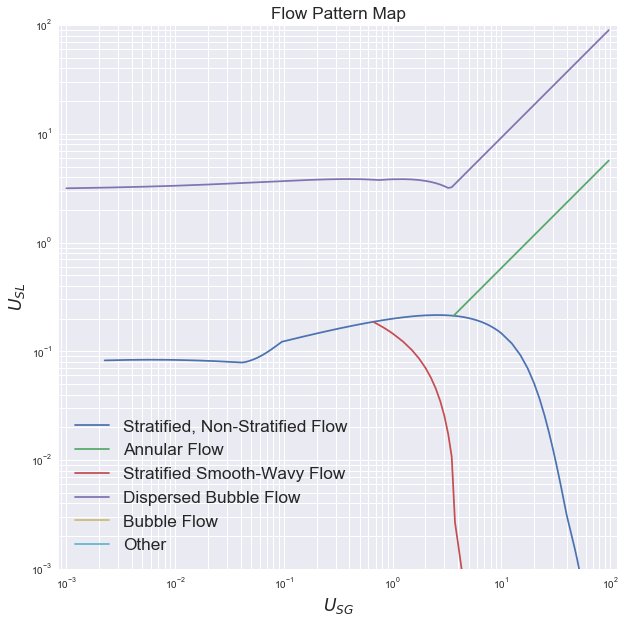

In [7]:
import seaborn
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(10,10))

plt.title('Flow Pattern Map', fontsize='x-large')

labels = ['Stratified, Non-Stratified Flow',
          'Annular Flow',
          'Stratified Smooth-Wavy Flow',
          'Dispersed Bubble Flow',
          'Bubble Flow', 'Other']

for i in range(error_matrix.shape[1]):
    x = transition_points[error_matrix[:, i] == 0, 2*i  ]
    y = transition_points[error_matrix[:, i] == 0, 2*i+1]
    plt.loglog(x, y, label=labels[i])

if PLOT_MESH:
    norm = matplotlib.colors.Normalize(vmin=0,vmax=5)

    plt.scatter(yv.flatten(), 
                xv.flatten(), 
                c=flow_pattern.flatten(), 
                cmap=plt.get_cmap('Set1'), 
                norm=norm)

plt.grid(b=True, which='both', color='w')
plt.axis('equal')
plt.legend(facecolor='w', fontsize='x-large')
plt.ylim((1e-3,100))
plt.xlim((1e-3,100))
plt.xlabel('$U_{SG}$', fontsize='x-large')
plt.ylabel('$U_{SL}$', fontsize='x-large')
plt.show()

## APPENDIX

### Some info about `PatFlow.dll`:
```
Dump of file PatFlow.dll
File Type: DLL
  Section contains the following exports for PatFlow.dll
    ordinal hint RVA      name
          1    0 00008A3B GLFPPRED
          3    1 000082D4 HLD
          5    2 00008439 HLDUP
          7    3 00007F78 PATFLOW
          9    4 0000859E VSGHLDCNT
         11    5 00008703 VSGVLCNT
         13    6 0000889F VSGVLCNTUP
          2    7 00008A3B _GLFPPRED@20
          4    8 000082D4 _HLD@20
          6    9 00008439 _HLDUP@20
          8    A 00007F78 _PATFLOW@28
         10    B 0000859E _VSGHLDCNT@20
         12    C 00008703 _VSGVLCNT@20
         14    D 0000889F _VSGVLCNTUP@20
```